<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/1D_Pitching_Moment_Higher_Frequency_Oscillations_PINN_Shafi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1D Pitching Moment Physics-Informed Neural Network (PINN) for Higher Frequency Oscillations**

#####This notebook contains the code to reproduce the plots using PINN presented in the paper "Limit Cycle Analysis Applied to the Oscillations of Decelerating Blunt-Body Entry Vehicles". by Mark Schoenenberger and Dr. Eric M. Queen, NASA Langley Research Center, Hampton, VA 23681
#####By the end of this notebook, you should be able to:
1.   code a PINN for Higher Frequency Oscillations.
1.   understand in more detail how PINNs are trained and how to improve their convergence.

**Problem overview**

#####The example problem we solve here is the 1D Pitching Moment Equation for Blunt-Body Entry Vehicles:
\begin{align}
      \ddot{α} - \frac{ρVSd^2} {4I} ({C}_{m_q} + {C}_{m_\dot{α}})\dot{α}-\frac{ρV^2Sd} {2I} {C}_{m_{α}}{α}=0
    \end{align}
#####As all coefficients are constant, this equation is a simple harmonic oscillator with damping, having the classic solution:
\begin{align}
      {α} = Ae^{\epsilon t} cos(ωt+δ)
    \end{align}
#####where
\begin{align}
      \epsilon = \frac{ρVSd^2} {8I} ({C}_{m_q} + {C}_{m_\dot{α}})
    \end{align}
#####and
\begin{align}
      \omega = \sqrt{-\frac{ρV^2Sd} {2I}{C}_{m_{α}}}
    \end{align}

**Environment**

In [66]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

**Helper function for saving GIFs**

In [67]:
from PIL import Image
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

**The analytical solution to the 1D Pitching Moment Equation**

In [68]:
def exact_solution(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))          # Multiply with 0.25 for Task 3
    cos = torch.cos(w*t + phi)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)
    exp = torch.exp(e*t)
    u = A*exp*cos
    return u

**Define a connected network**

In [69]:
class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

**Assign parameters**

In [70]:
# Main
A       = 1
ro      = 1.20
v       = 858
s       = 0.00385
d       = 0.07
CM_q_a  = -0.342            # CM_q_a  = np.array([0.15, 0, -0.171, -0.342])
CM_a    = -0.09
I       = 1.55e-4
phi     = 0

**Task 3: Train a PINN to simulate the system for low frequency**

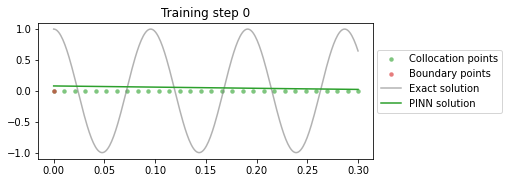

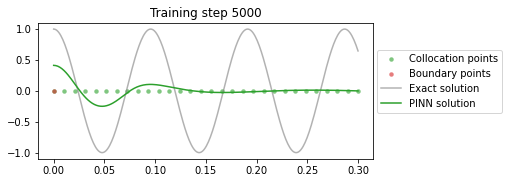

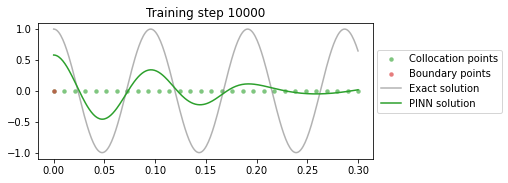

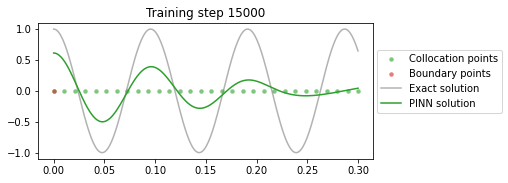

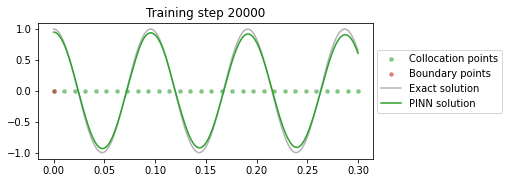

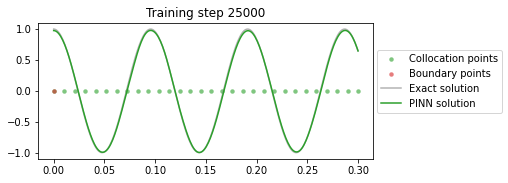

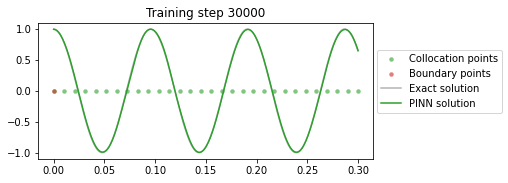

In [51]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,0.3,30).view(-1,1).requires_grad_(True)

# train the PINN
mu, k = -((ro*v*s*d**2)*(CM_q_a)/(4*I)), -((ro*v**2*s*d*CM_a)/(16*2*I))

t_test = torch.linspace(0,0.3,300).view(-1,1)
u_exact = exact_solution(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

files = []
for i in range(30001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 0.6e-5
    
    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, label="Collocation points", color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, label="Boundary points", color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend(loc=(1.01,0.34))

        file = "/content/sample_data/plots/standard_pinn_%.8i.png"%(i+1)     # create plot folder and define the directory
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if i % 5000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("standard_pinn.gif", files, fps=5, loop=0)

**Task 4: Train a PINN to simulate the system for high frequency**

#####The final task is to investigate how well the PINN scales to higher frequency oscillations and what can be done to improve its convergence.
#####Go back to Task 1 above, and see what happens when you increase $\omega$ to 0.25 to full scale 1.

**Approach: alternative "ansatz" formulation**
#####Ref: https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb

#####To speed up convergence, one way is to assume something about the solution.
#####For example, suppose we know from our physics intuition that the solution is in fact sinusodial.
#####Then, instead of having the PINN directly approximate the solution to the differential equation, i.e.
\begin{align}
      {u}_{PINN}(t;θ) \approx {u}(t)
    \end{align}
#####We instead use the PINN as part of a mathematical ansatz of the solution, i.e.
\begin{align}
      \hat{u}(t;θ,α,β) = {u}_{PINN}(t;θ)sin(αt+β) \approx {u}(t)
    \end{align}
#####where $\alpha$ and $\beta$ are treated as additional learnable parameters.
#####Comparing this ansatz to the exact solution
\begin{align}
      {α}(t) = Ae^{\epsilon t} cos(ωt+δ)
    \end{align}
#####We see that now the PINN only needs to learn the exponential function, which should be a much easier problem.
#####Again, autodifferentiation allows us to easily differentiate through this ansatz to train the PINN.

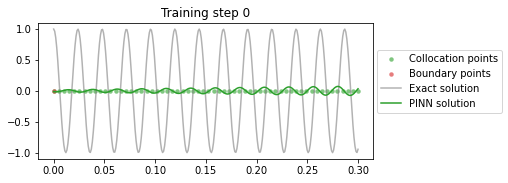

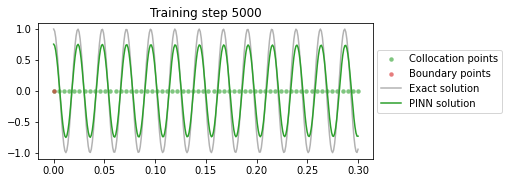

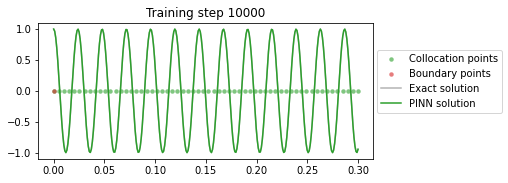

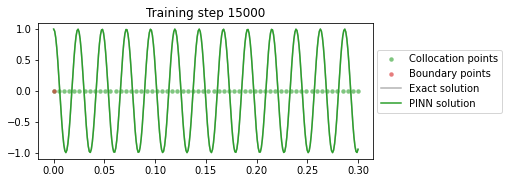

In [59]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,0.3,60).view(-1,1).requires_grad_(True)

# train the PINN
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))
k = -((ro*v**2*s*d*CM_a)/(2*I))

t_test = torch.linspace(0,0.3,300).view(-1,1)
u_exact = exact_solution(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t_test)
# add a,b to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[a,b],lr=1e-3)

files = []
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 0.5e-5
    
    # compute boundary loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_boundary)*torch.sin(a*t_boundary+b)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_physics)*torch.sin(a*t_physics+b)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, label="Collocation points", color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, label="Boundary points", color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend(loc=(1.01,0.34))

        file = "/content/sample_data/plots/high_osc_pinn_%.8i.png"%(i+1)     # create plot folder and define the directory
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if i % 5000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("high_osc_pinn.gif", files, fps=5, loop=0)

**Task 5: Train a PINN with positive damping CM_q_a**

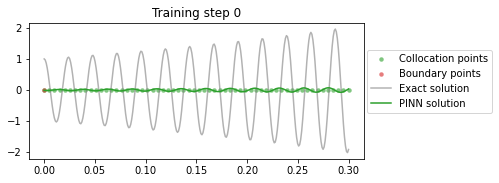

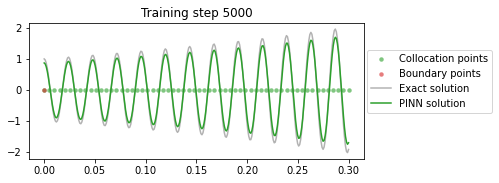

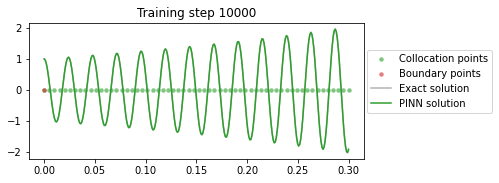

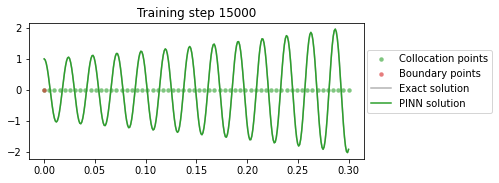

In [65]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,0.3,60).view(-1,1).requires_grad_(True)

# train the PINN
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))
k = -((ro*v**2*s*d*CM_a)/(2*I))

t_test = torch.linspace(0,0.3,300).view(-1,1)
u_exact = exact_solution(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t_test)
# add a,b to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[a,b],lr=1e-3)

files = []
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 0.5e-5
    
    # compute boundary loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_boundary)*torch.sin(a*t_boundary+b)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_physics)*torch.sin(a*t_physics+b)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, label="Collocation points", color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, label="Boundary points", color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend(loc=(1.01,0.34))

        file = "/content/sample_data/plots/damp_pinn_%.8i.png"%(i+1)     # create plot folder and define the directory
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if i % 5000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("damp_pinn.gif", files, fps=5, loop=0)

**Task 6: Train a PINN with negative damping CM_q_a**

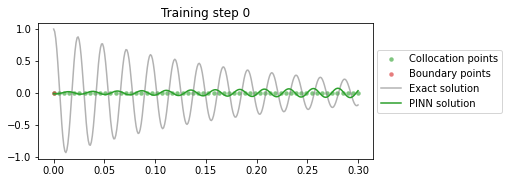

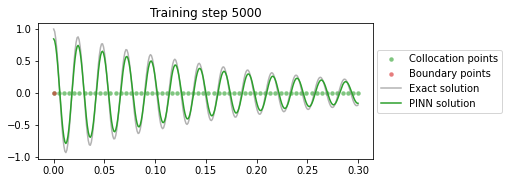

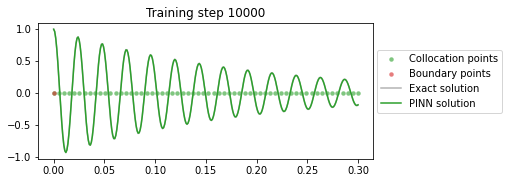

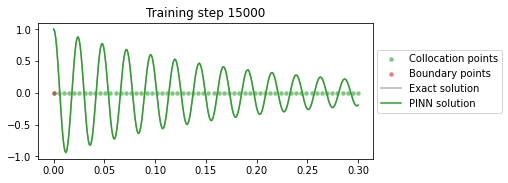

In [71]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,0.3,60).view(-1,1).requires_grad_(True)

# train the PINN
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))
k = -((ro*v**2*s*d*CM_a)/(2*I))

t_test = torch.linspace(0,0.3,300).view(-1,1)
u_exact = exact_solution(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t_test)
# add a,b to the optimiser
# TODO: write code here
optimiser = torch.optim.Adam(list(pinn.parameters())+[a,b],lr=1e-3)

files = []
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 0.5e-5
    
    # compute boundary loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_boundary)*torch.sin(a*t_boundary+b)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here (change to ansatz formulation)
    u = pinn(t_physics)*torch.sin(a*t_physics+b)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, label="Collocation points", color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, label="Boundary points", color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend(loc=(1.01,0.34))

        file = "/content/sample_data/plots/ndamp_pinn_%.8i.png"%(i+1)     # create plot folder and define the directory
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if i % 5000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("ndamp_pinn.gif", files, fps=5, loop=0)